In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# For feature importance (model-dependent and permutation-based)
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')  # To suppress warnings if desired


In [100]:
# E.g., reading from CSV – adapt to your actual file names or data sources
df_Kiwi = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")
df_Momondo = pd.read_csv("flight_data_momondo_All_combined_Cloud.csv")
# Clean the 'Price' column: Remove any non-digit characters and convert to float
df_Kiwi['Price'] = df_Kiwi['Price'].str.extract('(\d+)', expand=False).astype(float)
df_Momondo['Price'] = df_Momondo['Price'].str.extract('(\d+)', expand=False).astype(float)
df_Momondo = df_Momondo.dropna()  # creates a new DataFrame without rows containing NaN

In [101]:
print(df_Kiwi.info())
print(df_Kiwi.describe())
print(df_Kiwi.isnull().sum())
# ... similarly for df_Momondo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271981 entries, 0 to 271980
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Snap Date      271981 non-null  object 
 1   Dep Date       271981 non-null  object 
 2   Return Date    271981 non-null  object 
 3   Outbound       271981 non-null  object 
 4   Dep Time       271981 non-null  object 
 5   Dep Duration   271981 non-null  object 
 6   Dep Arrival    271981 non-null  object 
 7   From           271981 non-null  object 
 8   Stops          271981 non-null  int64  
 9   Landing        271981 non-null  object 
 10  Inbound        271981 non-null  object 
 11  Back Time      271981 non-null  object 
 12  Back Duration  271981 non-null  object 
 13  Back Arrival   271981 non-null  object 
 14  From.1         271981 non-null  object 
 15  Stops.1        271981 non-null  int64  
 16  Landing.1      271981 non-null  object 
 17  Dep Company    271981 non-nul

In [102]:
print(df_Momondo.info())
print(df_Momondo.describe())
print(df_Momondo.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279681 entries, 0 to 281926
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Snap Date                      279681 non-null  object 
 1   Dep Date                       279681 non-null  object 
 2   Return Date                    279681 non-null  object 
 3   Dep time                       279681 non-null  object 
 4   Dep Company                    279681 non-null  object 
 5   Stops                          279681 non-null  object 
 6   Dep Duration                   279681 non-null  object 
 7   From Airport                   279681 non-null  object 
 8   Landing Airport                279681 non-null  object 
 9   Back Time                      279681 non-null  object 
 10  Back Company                   279681 non-null  object 
 11  Stops.1                        279681 non-null  object 
 12  Back Duration                 

In [103]:
def create_additional_features(df):
    # From columns: 'Dep Date', 'Return Date', 'Snap Date'
    # We convert them to datetime:
    df['Dep Date'] = pd.to_datetime(df['Dep Date'])
    df['Return Date'] = pd.to_datetime(df['Return Date'])
    df['Snap Date'] = pd.to_datetime(df['Snap Date'])

    # Day of week (Monday=0, Sunday=6)
    df['outbound_dayofweek'] = df['Dep Date'].dt.dayofweek
    df['return_dayofweek'] = df['Return Date'].dt.dayofweek

    # Proximity to month-end
    df['outbound_day'] = df['Dep Date'].dt.day
    df['return_day'] = df['Return Date'].dt.day

    # TTT (Time to Travel): difference in days between Snap Date and Dep Date
    df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

    # LOS (Length of Stay): diference in nights between Dep Date and Return Date
    df['LOS'] = (df['Return Date'] - df['Dep Date']).dt.days

    # Example: Interaction feature
    df['TTT_LOS_interaction'] = df['TTT'] * df['LOS']

    # We drop any rows with negative or invalid TTT/LOS if they appear (just in case...)
    df = df[df['TTT'] >= 0]
    df = df[df['LOS'] > 0]

    # Return the updated dataframe
    return df

df_Kiwi = create_additional_features(df_Kiwi)
df_Momondo = create_additional_features(df_Momondo)


In [104]:
#Train-Test Split (Step 3.2)
features = [
    'TTT', 'LOS', 'outbound_dayofweek', 'return_dayofweek',
    'outbound_day', 'return_day', 'TTT_LOS_interaction'
]
target = 'Price'  # adapt if your Price column is named differently

X_site1 = df_Kiwi[features].copy()
y_site1 = df_Kiwi[target].copy()

X_site2 = df_Momondo[features].copy()
y_site2 = df_Momondo[target].copy()

X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X_site1, y_site1, test_size=0.35, random_state=42
)
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    X_site2, y_site2, test_size=0.35, random_state=42
)


In [105]:
#Experiment with Different Normalization Methods (Step 3.8)
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}
def scale_data(X_train, X_test, scaler):
    if scaler is None:
        return X_train, X_test
    else:
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

In [106]:
#Evaluation Function & Residual Plot (Steps 3.5 & 3.6)
def evaluate_model(model_name, model, y_train, y_pred_train, y_test, y_pred_test, scaler_name=None):
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Residual plot
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.5, label='Train')
    plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.5, label='Test')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name} [Scaler={scaler_name}]')
    plt.legend()
    plt.show()

    return {
        'Model': model_name,
        'Scaler': scaler_name,
        'MSE_Train': mse_train,
        'MSE_Test': mse_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'R2_Train': r2_train,
        'R2_Test': r2_test
    }

In [107]:
#Regression Algorithms (Step 3.1, 3.3)
def train_and_evaluate_models(X_train, X_test, y_train, y_test, scaler_name=None):
    results = []

    # 1) LinearRegression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    results.append(
        evaluate_model("LinearRegression", lr, y_train, y_pred_train, y_test, y_pred_test, scaler_name)
    )

    # 2) DecisionTreeRegressor
    # Example of a small param grid; you can expand
    for depth in [3, 5, 7]:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train, y_train)
        y_pred_train = dt.predict(X_train)
        y_pred_test = dt.predict(X_test)

        results.append(
            evaluate_model(f"DecisionTree(d={depth})", dt, y_train, y_pred_train, y_test, y_pred_test, scaler_name)
        )

    # 3) GaussianProcessRegressor
    # Example: try different kernels
    # Example: try different kernels
    kernels = [
        DotProduct() + WhiteKernel(),
        RBF(length_scale=1.0) + WhiteKernel()
    ]
    for kernel in kernels:
        try:
            gpr = GaussianProcessRegressor(kernel=kernel,optimizer=None,alpha=1e-6, random_state=42)
            gpr.fit(X_train, y_train)
            y_pred_train = gpr.predict(X_train)
            y_pred_test = gpr.predict(X_test)

            results.append(
            evaluate_model(f"GPR({kernel})", gpr, y_train, y_pred_train, y_test, y_pred_test, scaler_name)
            )
        except Exception as e:
            print(f"Err with kernel{kernel}: {e}")


    # 4) RandomForestRegressor
    # Just an example; you could do a loop or GridSearch
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    results.append(
        evaluate_model("RandomForest", rf, y_train, rf.predict(X_train), y_test, rf.predict(X_test), scaler_name)
    )

    # 5) KNeighborsRegressor
    for k in [3, 5, 7]:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        results.append(
            evaluate_model(f"KNN(k={k})", knn, y_train, knn.predict(X_train), y_test, knn.predict(X_test), scaler_name)
        )

    # 6) GradientBoostingRegressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)
    results.append(
        evaluate_model("GBR", gbr, y_train, gbr.predict(X_train), y_test, gbr.predict(X_test), scaler_name)
    )

    return pd.DataFrame(results)


TTT: 0.3483
LOS: 0.0201
outbound_dayofweek: 0.3101
return_dayofweek: 0.2029
outbound_day: 0.0623
return_day: 0.0076
TTT_LOS_interaction: 0.0488


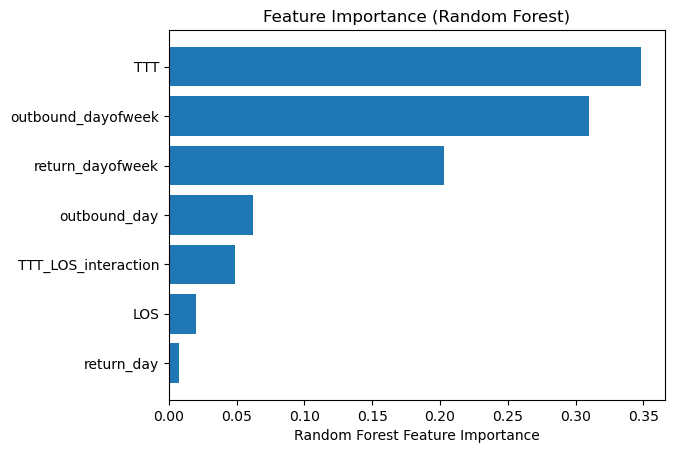

In [108]:
#Feature Importance (Step 3.5)
# Model-Based
# Decision Tree / Random Forest / Gradient Boosting
# 1. Lets train a RandomForestRegressor on our data
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_s1, y_train_s1)

# 2. Access feature_importances_
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    
    # 3. Print or plot them
    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.4f}")

    # (Optional) Visualize
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.argsort(importances)
    plt.barh([features[i] for i in indices], importances[indices])
    plt.xlabel("Random Forest Feature Importance")
    plt.title("Feature Importance (Random Forest)")
    plt.show()

TTT: 0.4614
LOS: 0.0151
outbound_dayofweek: 0.1506
return_dayofweek: 0.1851
outbound_day: 0.0899
return_day: 0.0104
TTT_LOS_interaction: 0.0875


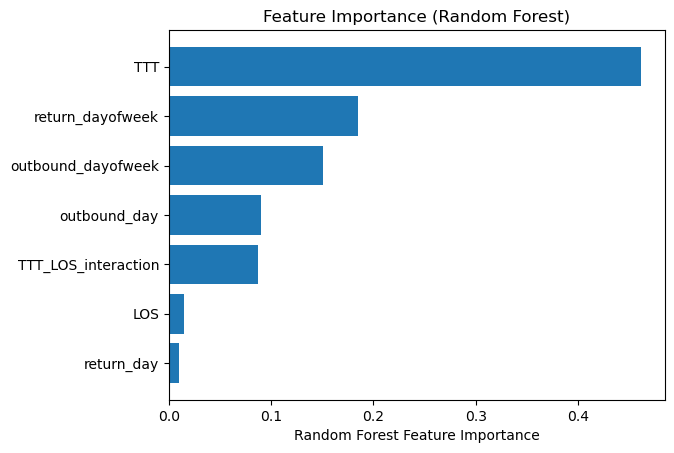

In [109]:
# 1. Lets train a RandomForestRegressor on our second site- (Momondo data)
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_s2, y_train_s2)

# 2. Access feature_importances_
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    
    # 3. Print or plot them
    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.4f}")

    # (Optional) Visualize
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.argsort(importances)
    plt.barh([features[i] for i in indices], importances[indices])
    plt.xlabel("Random Forest Feature Importance")
    plt.title("Feature Importance (Random Forest)")
    plt.show()

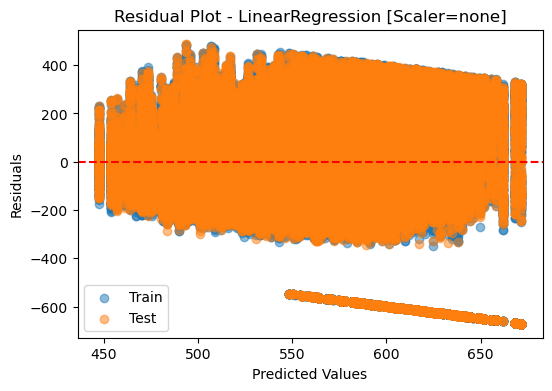

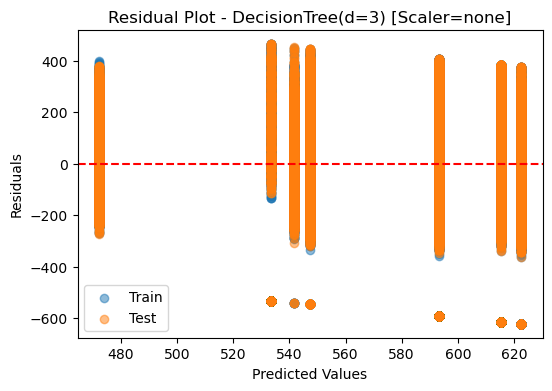

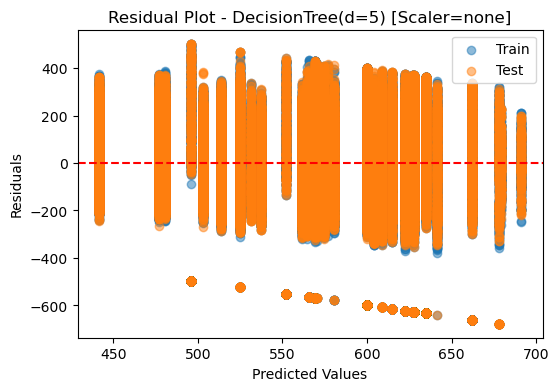

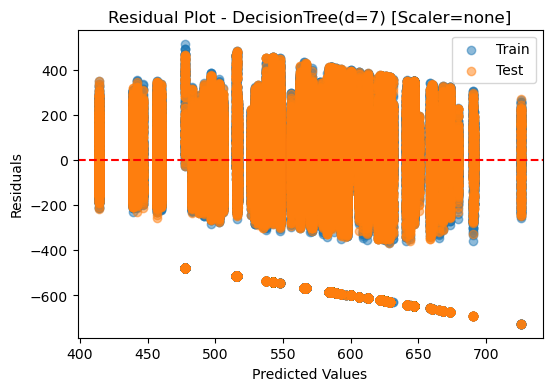

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 233. GiB for an array with shape (176787, 176787) and data type int64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 116. GiB for an array with shape (15626733291,) and data type float64


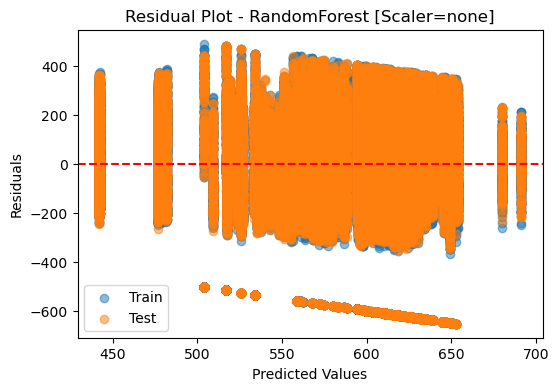

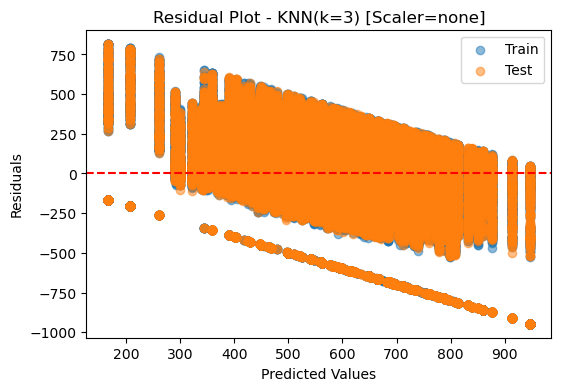

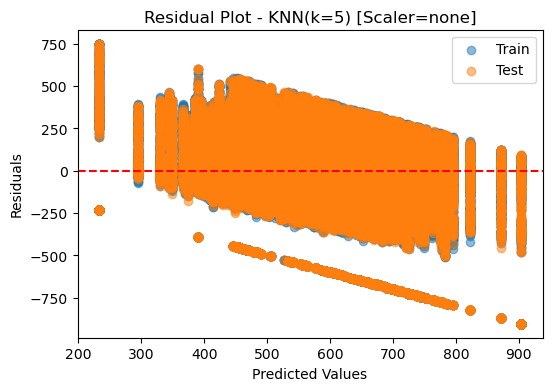

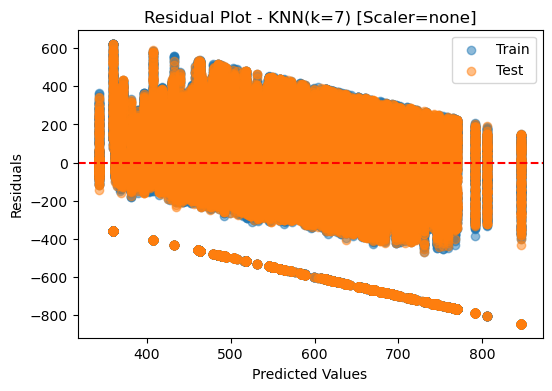

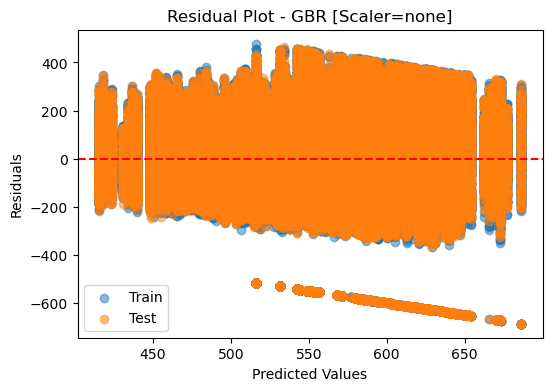

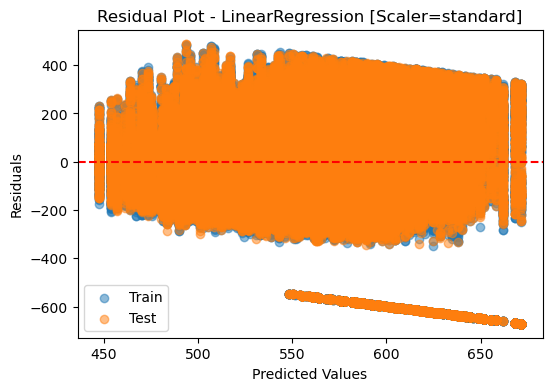

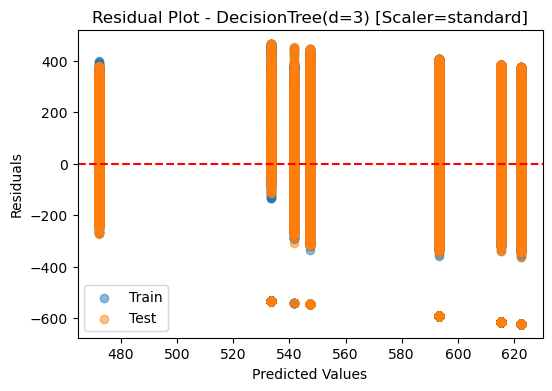

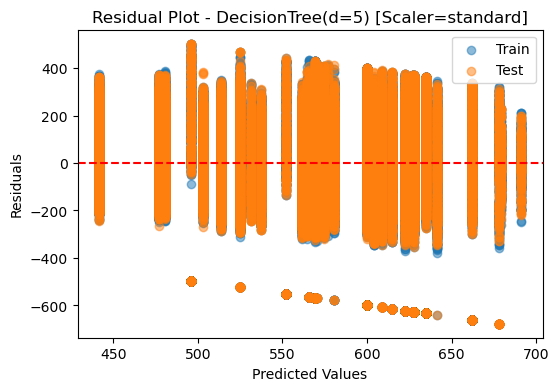

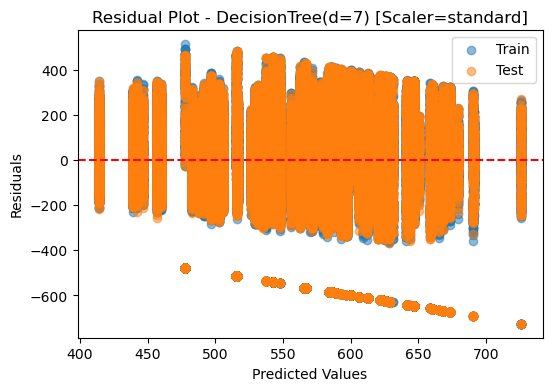

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 233. GiB for an array with shape (176787, 176787) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 116. GiB for an array with shape (15626733291,) and data type float64


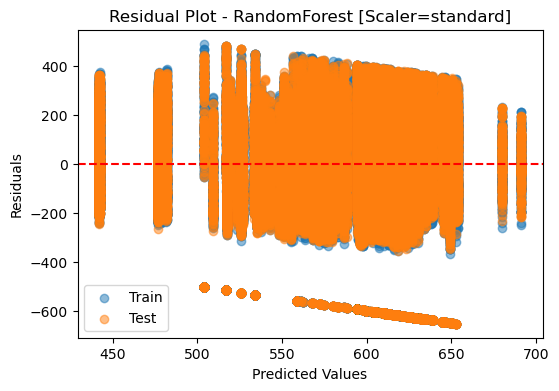

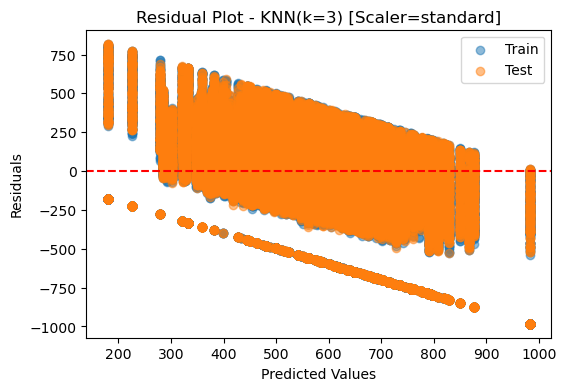

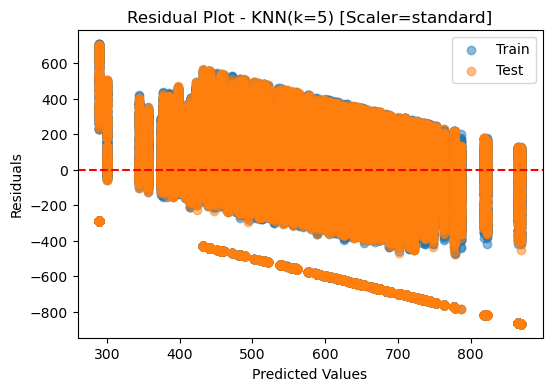

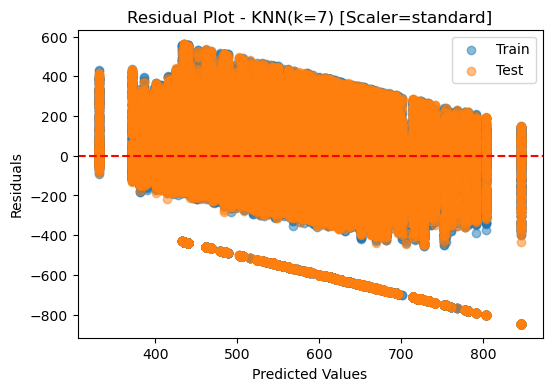

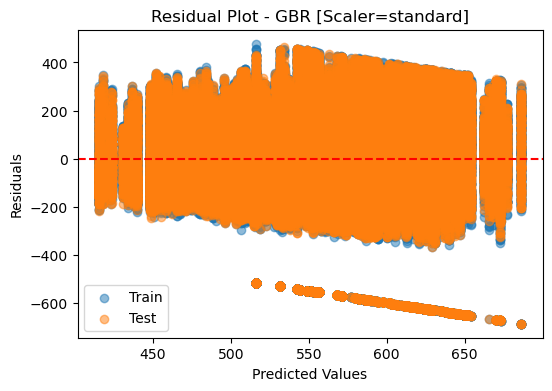

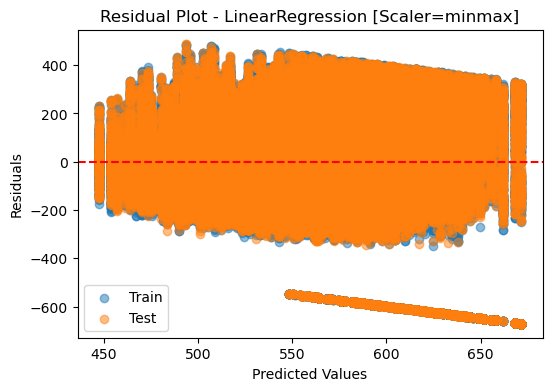

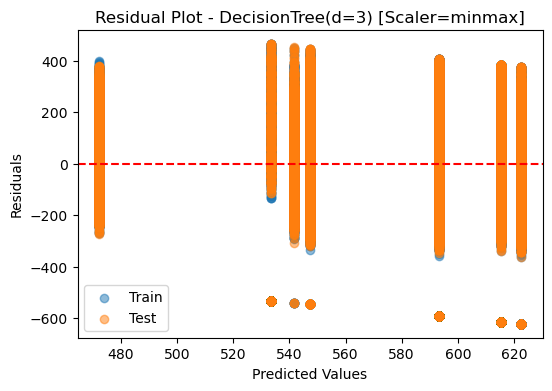

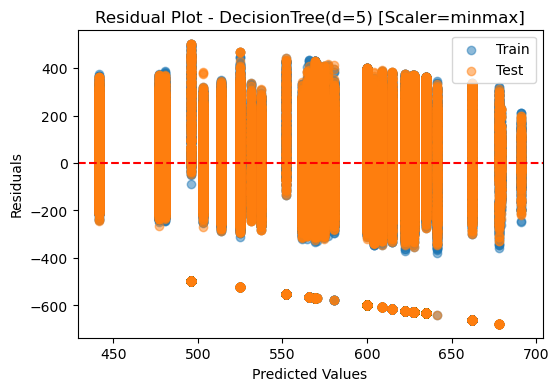

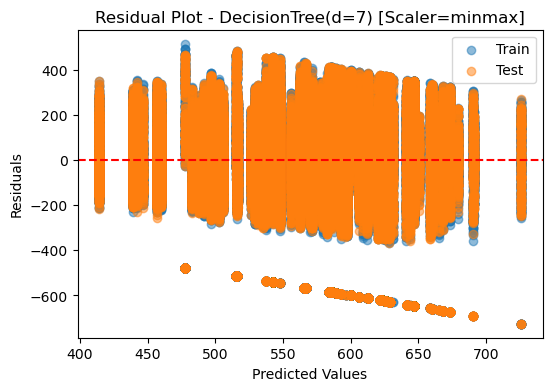

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 233. GiB for an array with shape (176787, 176787) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 116. GiB for an array with shape (15626733291,) and data type float64


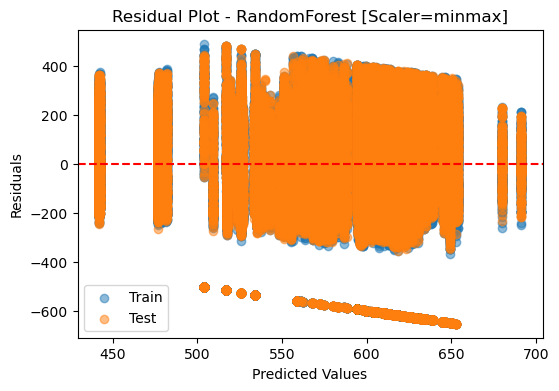

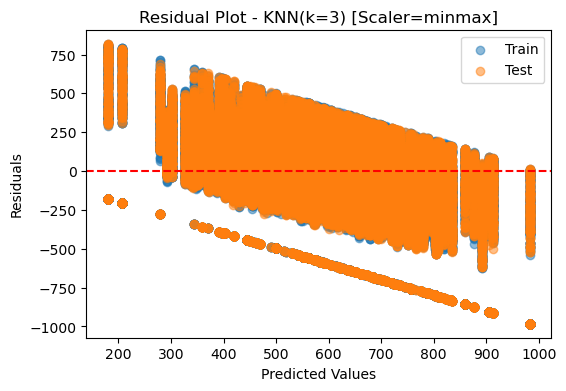

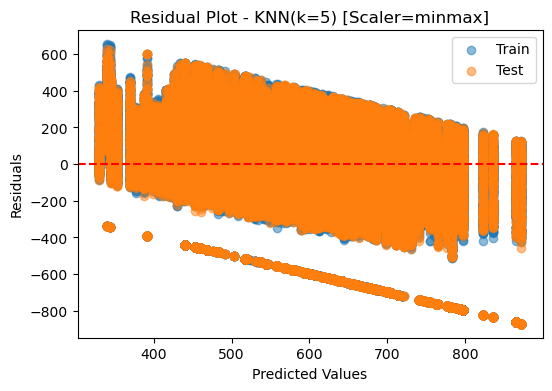

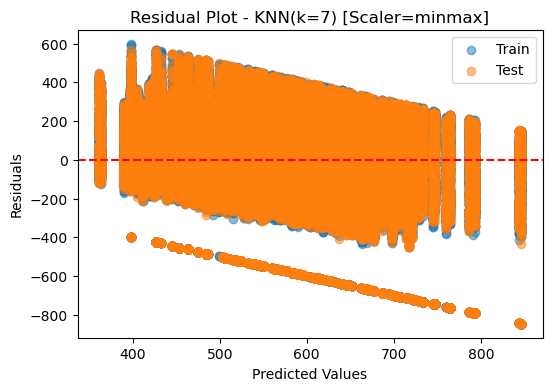

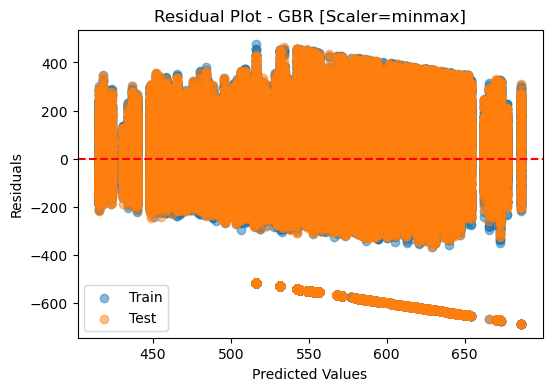

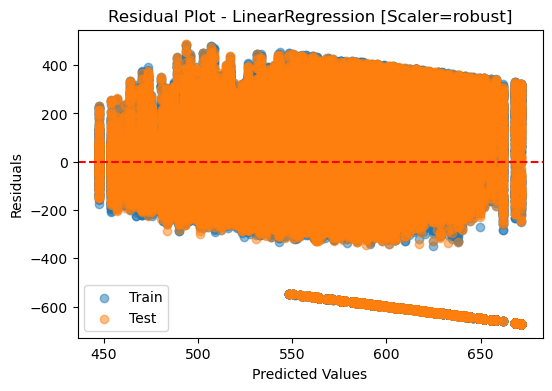

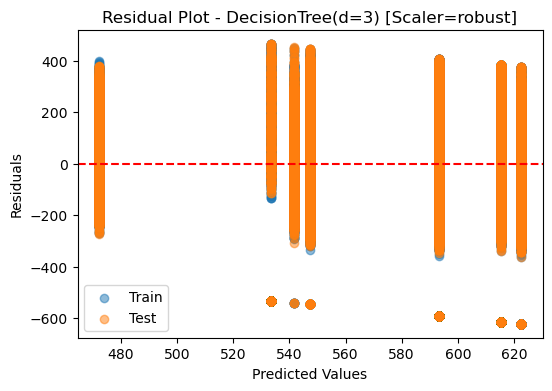

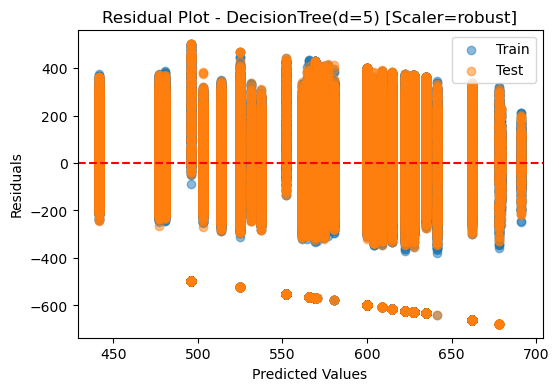

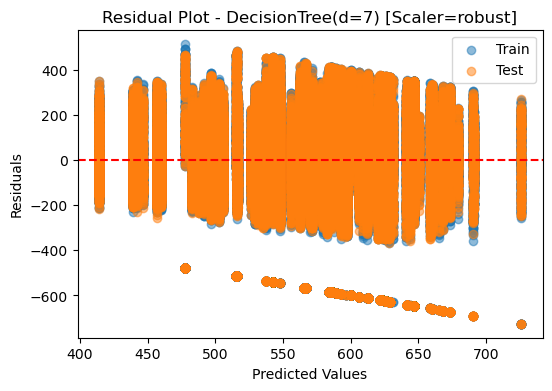

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 233. GiB for an array with shape (176787, 176787) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 116. GiB for an array with shape (15626733291,) and data type float64


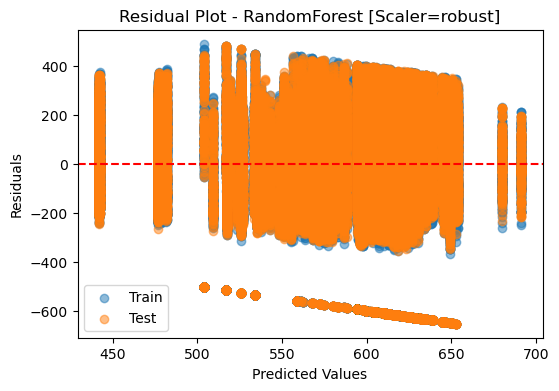

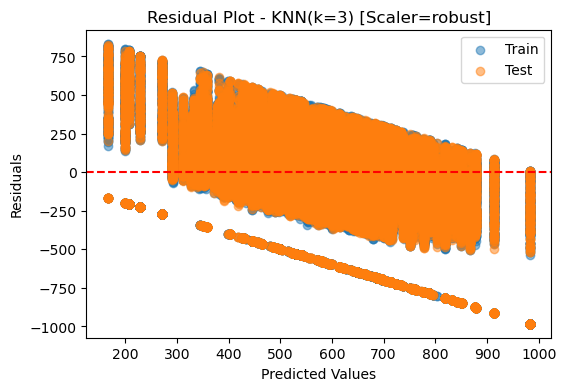

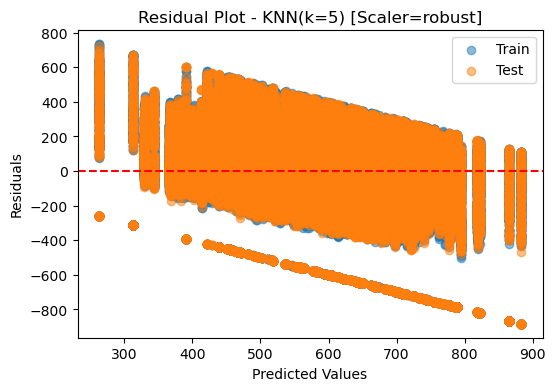

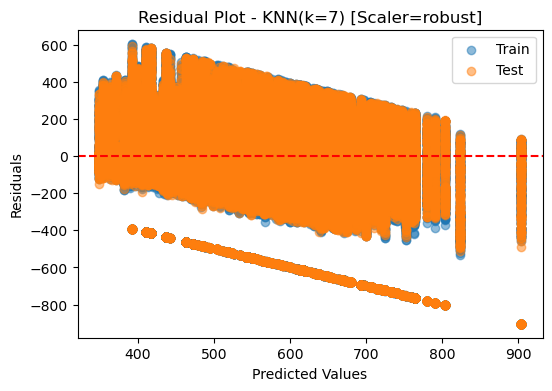

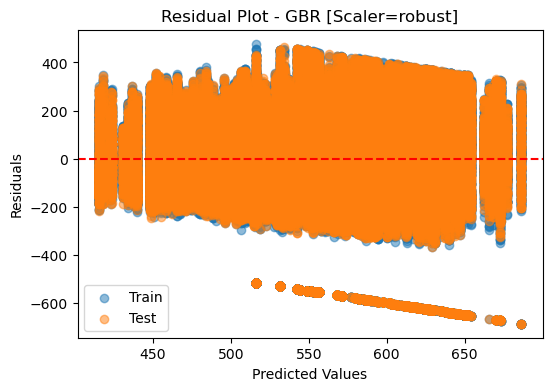

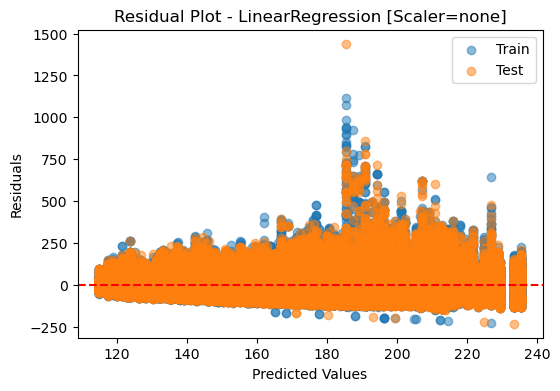

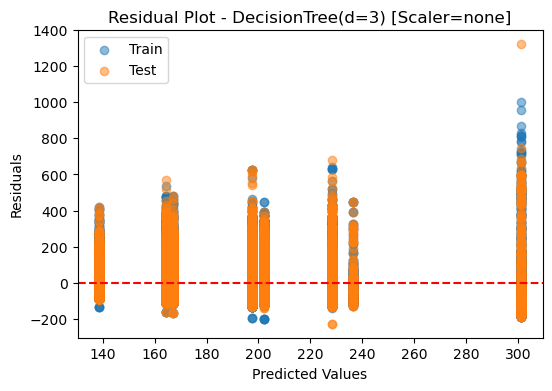

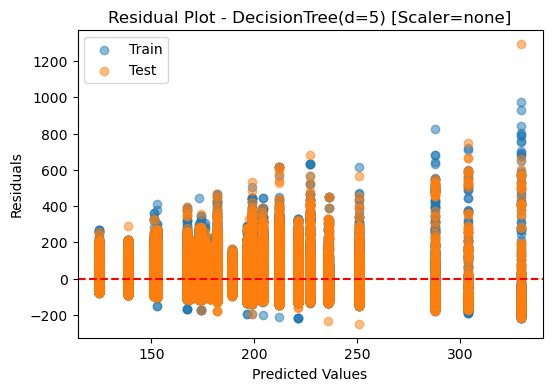

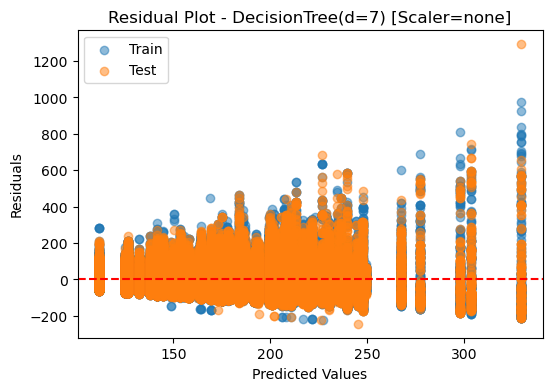

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 246. GiB for an array with shape (181792, 181792) and data type int64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 123. GiB for an array with shape (16524074736,) and data type float64


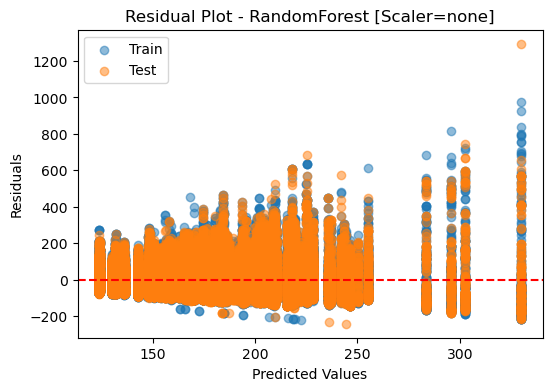

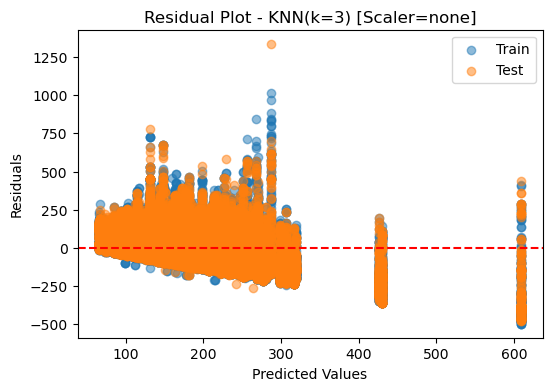

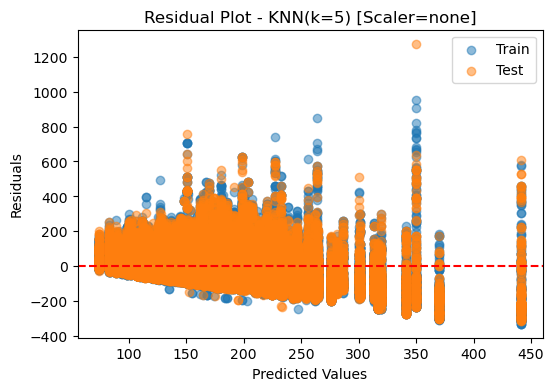

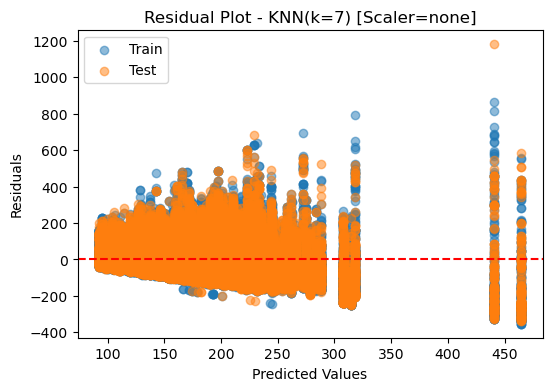

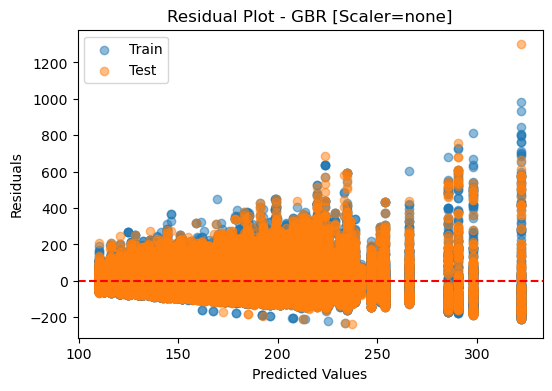

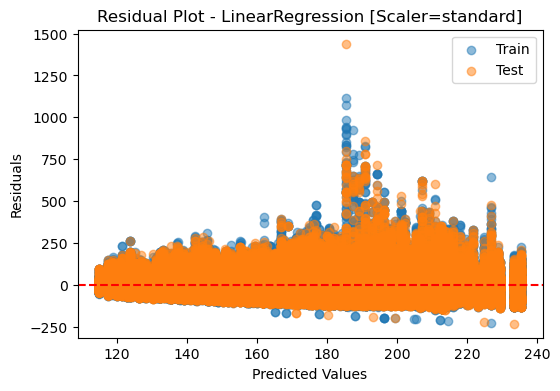

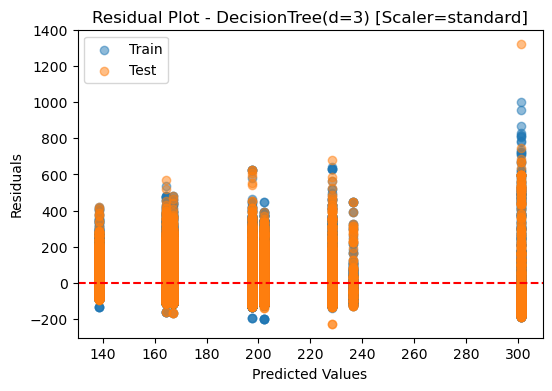

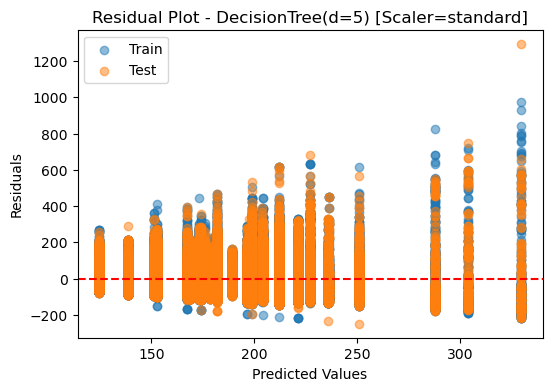

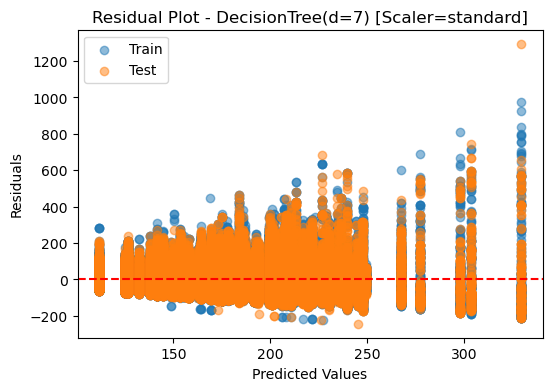

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 246. GiB for an array with shape (181792, 181792) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 123. GiB for an array with shape (16524074736,) and data type float64


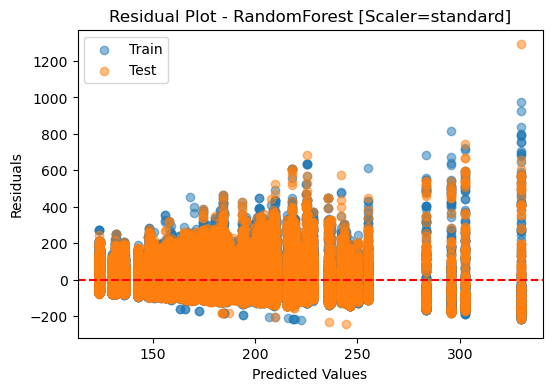

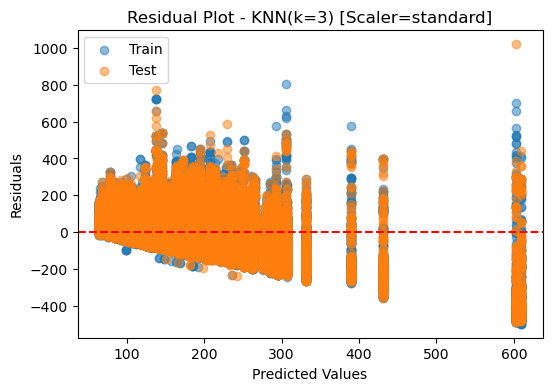

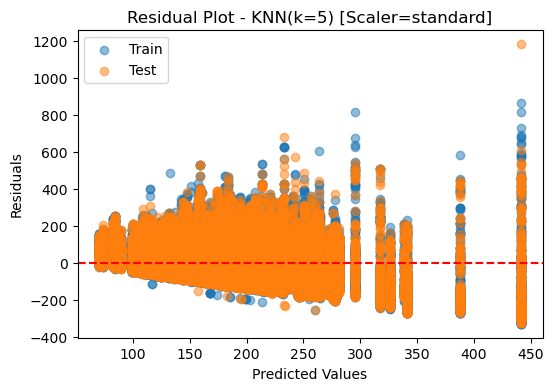

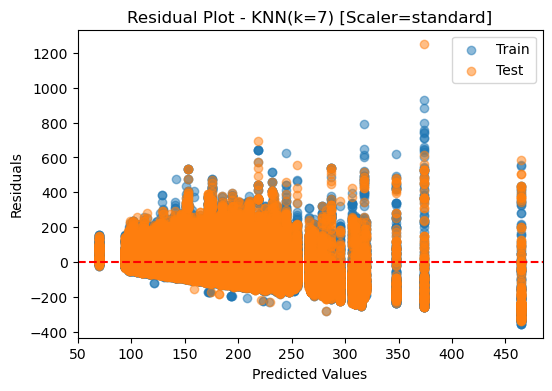

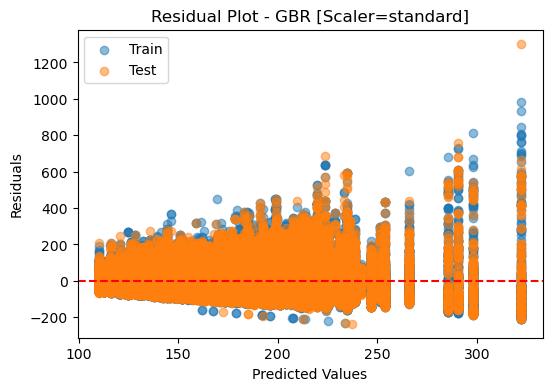

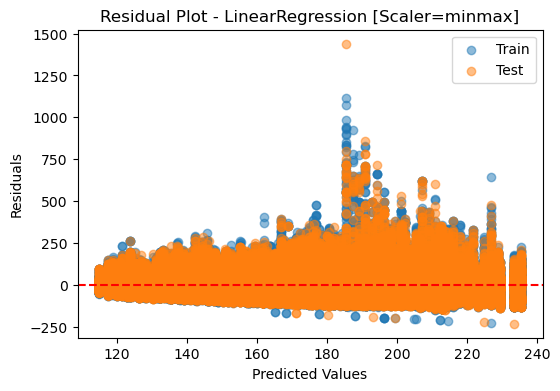

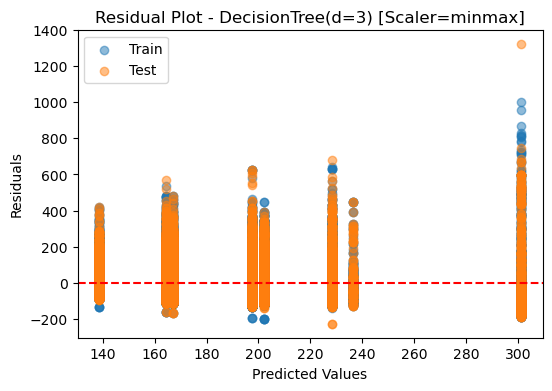

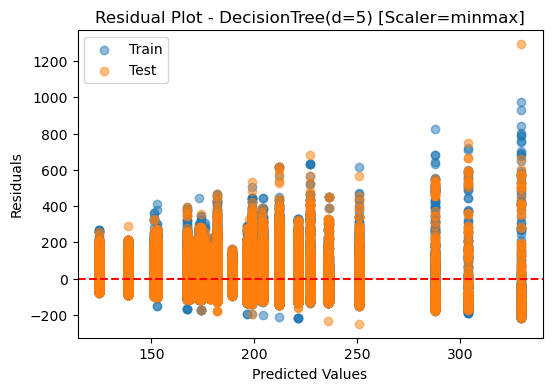

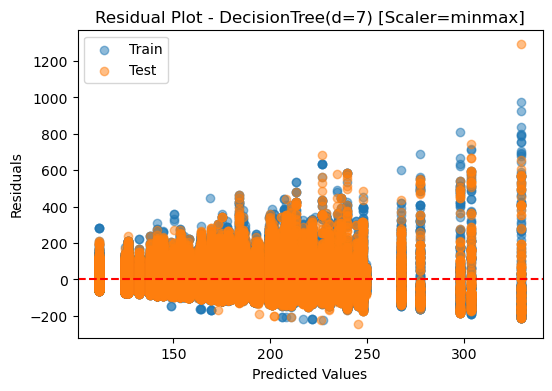

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 246. GiB for an array with shape (181792, 181792) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 123. GiB for an array with shape (16524074736,) and data type float64


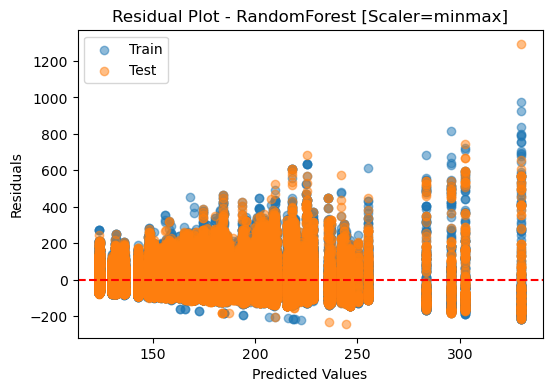

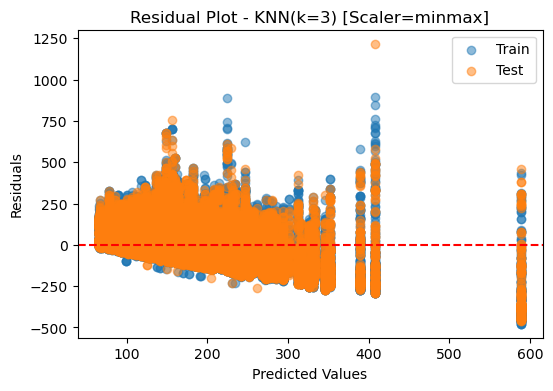

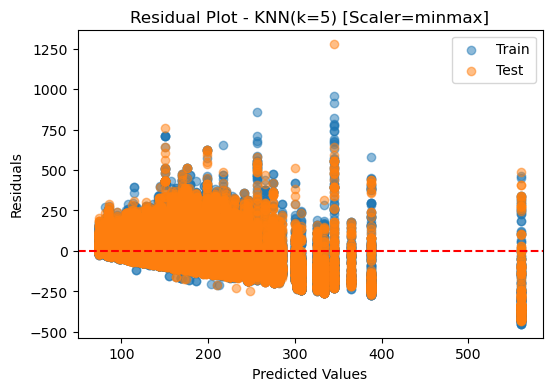

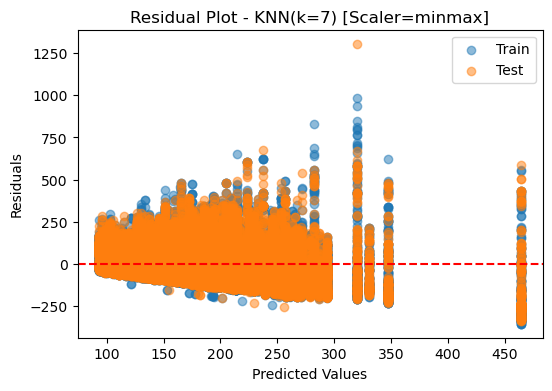

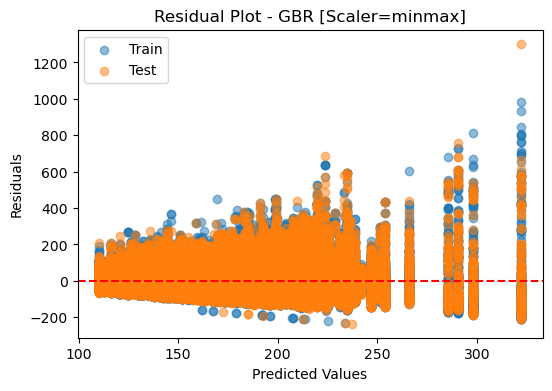

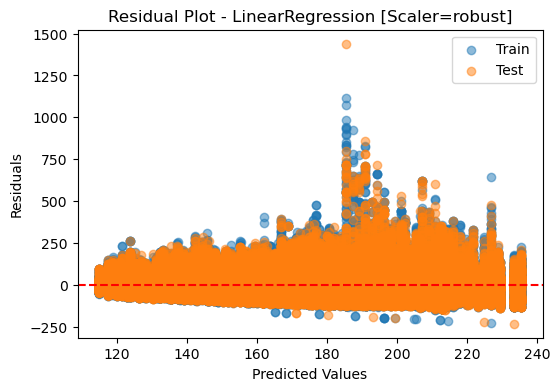

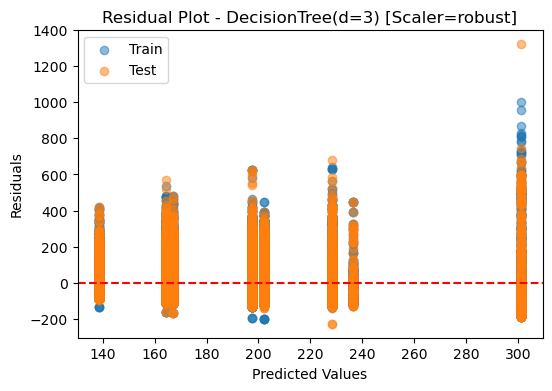

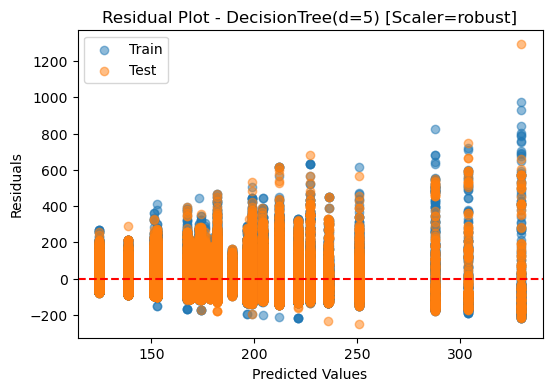

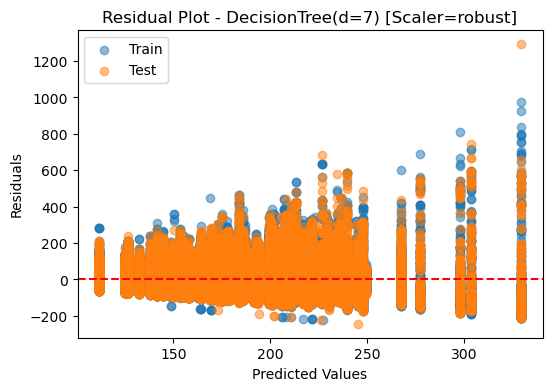

Err with kernelDotProduct(sigma_0=1) + WhiteKernel(noise_level=1): Unable to allocate 246. GiB for an array with shape (181792, 181792) and data type float64
Err with kernelRBF(length_scale=1) + WhiteKernel(noise_level=1): Unable to allocate 123. GiB for an array with shape (16524074736,) and data type float64


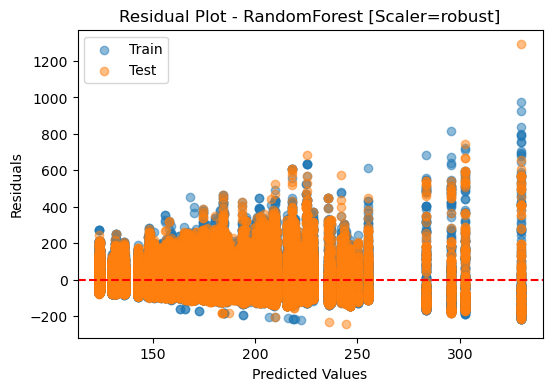

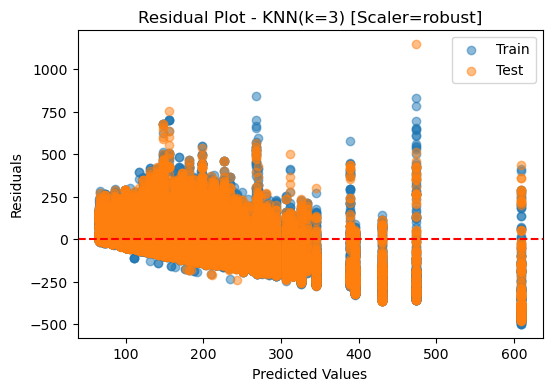

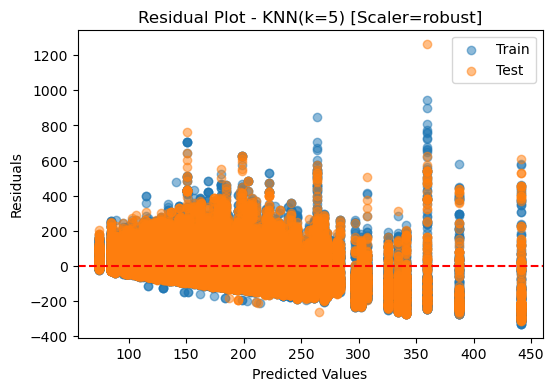

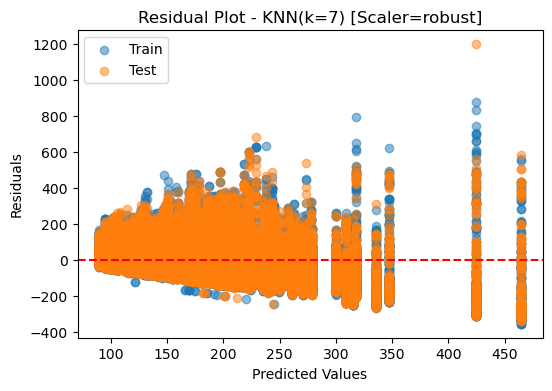

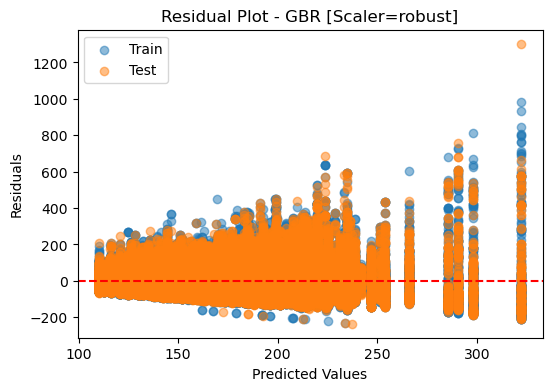

Model    Scaler     MSE_Train      MSE_Test  RMSE_Train  \
44                GBR    robust   4514.242582   4499.379705   67.188113   
39  DecisionTree(d=7)    robust   4529.976199   4521.857306   67.305098   
40       RandomForest    robust   4612.127576   4595.028939   67.912647   
38  DecisionTree(d=5)    robust   4675.930502   4652.809565   68.380776   
37  DecisionTree(d=3)    robust   4881.563727   4851.607818   69.868188   
17                GBR  standard  29056.822104  28959.020043  170.460617   
8                 GBR      none  29056.822104  28959.020043  170.460617   
35                GBR    robust  29056.822104  28959.020043  170.460617   
26                GBR    minmax  29056.822104  28959.020043  170.460617   
3   DecisionTree(d=7)      none  29130.308648  29078.744544  170.676034   
30  DecisionTree(d=7)    robust  29130.308648  29078.744544  170.676034   
12  DecisionTree(d=7)  standard  29130.308648  29078.744544  170.676034   
21  DecisionTree(d=7)    minmax  29130.308648  29078.744544  170.676034   
36   LinearRegression    robust   4959.322838   4934.524561   70.422460   
31       RandomForest    robust  29561.622689  29462.049089  171.934937   
22       RandomForest    minmax  29561.622689  29462.049089  171.934937   
4        RandomForest      none  29561.622689  29462.049089  171.934937   
13       RandomForest  standard  29561.622689  29462.049089  171.934937   
11  DecisionTree(d=5)  standard  29682.798559  29612.319466  172.286966   
20  DecisionTree(d=5)    minmax  29682.798559  29612.319466  172.286966   
2   DecisionTree(d=5)      none  29682.798559  29612.319466  172.286966   
29  DecisionTree(d=5)    robust  29682.798559  29612.319466  172.286966   
28  DecisionTree(d=3)    robust  30441.732217  30354.435100  174.475592   
19  DecisionTree(d=3)    minmax  30441.732217  30354.435100  174.475592   
1   DecisionTree(d=3)      none  30441.732217  30354.435100  174.475592   
10  DecisionTree(d=3)  standard  30441.732217  30354.435100  174.475592   
43           KNN(k=7)    robust   5103.068764   5110.094942   71.435767   
9    LinearRegression  standard  31047.371146  30959.288306  176.202642   
0    LinearRegression      none  31047.371146  30959.288306  176.202642   
27   LinearRegression    robust  31047.371146  30959.288306  176.202642   
18   LinearRegression    minmax  31047.371146  30959.288306  176.202642   
42           KNN(k=5)    robust   5352.575514   5346.228872   73.161298   
16           KNN(k=7)  standard  32556.001941  32442.492908  180.432818   
7            KNN(k=7)      none  32516.366147  32452.531399  180.322950   
25           KNN(k=7)    minmax  32789.260091  32620.141618  181.078050   
34           KNN(k=7)    robust  32848.274784  32671.143078  181.240930   
6            KNN(k=5)      none  34044.425902  33996.666058  184.511316   
15           KNN(k=5)  standard  34176.101934  33999.339410  184.867796   
24           KNN(k=5)    minmax  34527.213035  34263.035967  185.814997   
33           KNN(k=5)    robust  34538.123414  34360.355699  185.844353   
41           KNN(k=3)    robust   6140.067452   6127.016722   78.358583   
5            KNN(k=3)      none  37471.766773  37438.802774  193.576256   
14           KNN(k=3)  standard  38461.059712  38302.699644  196.114915   
32           KNN(k=3)    robust  38855.808084  38730.958898  197.118766   
23           KNN(k=3)    minmax  39005.703197  38806.503992  197.498616   

     RMSE_Test   MAE_Train    MAE_Test  R2_Train   R2_Test  
44   67.077416   51.998508   52.026184  0.186407  0.185275  
39   67.244757   52.148443   52.219267  0.183572  0.181205  
40   67.786643   52.619780   52.639416  0.168766  0.167955  
38   68.211506   52.943005   52.916991  0.157267  0.157493  
37   69.653484   54.022028   53.926946  0.120206  0.121495  
17  170.173500  133.519333  133.450941  0.115604  0.120083  
8   170.173500  133.519333  133.450941  0.115604  0.120083  
35  170.173500  133.519333  133.450941  0.115604  0.120083  
26  170.173500  

In [110]:
#Running Everything for Kiwi and Momondo (Step 3.9)
all_results_site1 = pd.DataFrame()

for scaler_name, scaler_obj in scalers.items():
    X_train_scaled, X_test_scaled = scale_data(X_train_s1, X_test_s1, scaler_obj)
    results_df = train_and_evaluate_models(
        X_train_scaled, X_test_scaled,
        y_train_s1, y_test_s1,
        scaler_name=scaler_name
    )
    all_results_site1 = pd.concat([all_results_site1, results_df], ignore_index=True)

for scaler_name, scaler_obj in scalers.items():
    X_train_scaled, X_test_scaled = scale_data(X_train_s2, X_test_s2, scaler_obj)
    results_df = train_and_evaluate_models(
        X_train_scaled, X_test_scaled,
        y_train_s2, y_test_s2,
        scaler_name=scaler_name
    )
    all_results_site2 = pd.concat([all_results_site1, results_df], ignore_index=True)
# Sort or group by best R2_Test or lowest RMSE_Test, etc.
all_results_site1.sort_values(by='R2_Test', ascending=False)
all_results_site2.sort_values(by='R2_Test', ascending=False)



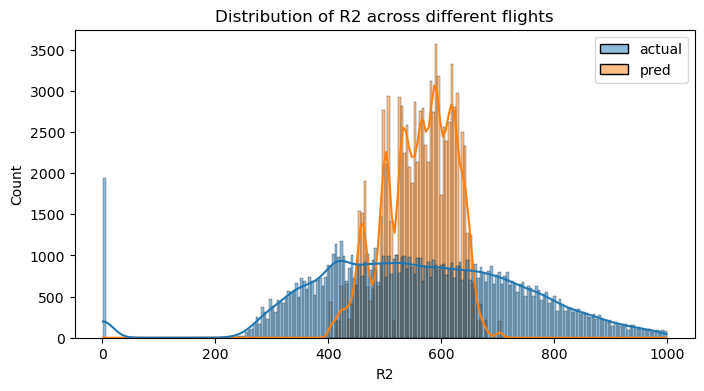

In [117]:
#Analyzing the Distribution of R² Errors (Step 3.10)
# Suppose your dataset has columns: 'flight_id' or something that identifies unique flights
best_model = GradientBoostingRegressor().fit(X_test_s1,y_test_s1)  # your chosen best model
X_test = X_test_s1
y_test = y_test_s1

y_pred_test = best_model.predict(X_test)

# Calculate R2 per flight_id
df_test_results = pd.DataFrame({
    'actual': y_test,
    'pred': y_pred_test
})
r2_by_flight = df_test_results

plt.figure(figsize=(8,4))
sns.histplot(r2_by_flight, kde=True)
plt.title("Distribution of R2 across different flights")
plt.xlabel("R2")
plt.ylabel("Count")
plt.show()

In [120]:
#Future-Oriented Train/Test Split (Step 3.11)
df_train_future = df_Kiwi[df_Kiwi['TTT'] <= 25]
df_test_future  = df_Kiwi[df_Kiwi['TTT'] > 25]

X_train_future = df_train_future[features]
y_train_future = df_train_future[target]

X_test_future = df_test_future[features]
y_test_future = df_test_future[target]

# Possibly scale again
X_train_future_scaled, X_test_future_scaled = scale_data(X_train_future, X_test_future, StandardScaler())

# Fit best model from earlier or retrain a new one:
best_model_future = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
best_model_future.fit(X_train_future_scaled, y_train_future)

y_pred_future = best_model_future.predict(X_test_future_scaled)

# Compute metrics
mse_future = mean_squared_error(y_test_future, y_pred_future)
rmse_future = np.sqrt(mse_future)
r2_future = r2_score(y_test_future, y_pred_future)
print("Future Split Results:")
print(f"MSE: {mse_future}, RMSE: {rmse_future}, R2: {r2_future}")


Future Split Results:
MSE: 18401.126848767864, RMSE: 135.65075321857915, R2: -0.07028064011707058
